In [4]:
#simple direct problem solving 
import matplotlib.pyplot as plt

from solution_global_wip import Solution
from basis import Basis
import itertools
import numpy as np

def prepare_model(border_weight, colloc_weight, connect_weights):


    # SET ACCURATE PHI
    eps = 0.005

    power = 5
    params = {
        'n_dims': 2,
        'dim_sizes': np.array([6, 6]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }
    sol = Solution(**params)

    w = colloc_weight
    k1, k2 = connect_weights
    # k2 = 1
    # border_weight = 1 #sol.steps[0]**(-1) *100

    # border_weight = 100

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


    connect_points = np.array([[-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],])
                                
    border_points = connect_points

    colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                                -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                                u_loc([0,1],0)*u_bas([0,1],1)+

                                                                                                u_loc([0,0],0)*u_bas([0,2],1)+
                                                                                                u_bas([0,0],0)*u_loc([0,2],1))
                                                                                            ) * w**2,
                            lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                                +2*(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                                ) * w**2 ,]

    def popravka(f,g):
        return f*g
    colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: -popravka(u_loc([0,1],0), u_loc([0,1],1)) - popravka(u_loc([0,0],0), u_loc([0,2],1)),  #2*u_loc([0,0],0)*u_loc([0,1],1)**2 * w**2, #0, 

                            lambda u_loc, u_nei, x, x_loc: (popravka(u_loc([0,1],0), u_loc([0,1],1))) * w**2]
    colloc_ops = [colloc_left_operators, colloc_right_operators]


    def initial_state(x):
        t, x = x
        sm_x = 3*x-1
        if (x<2/3 and x>1/3):
            return 3*12*sm_x**2 *(1-sm_x)
        else:
            return 0


    def terminal_state(x):
        sm_x = 3*x-1
        if (x<2/3 and x>1/3):
            return 3*12*sm_x*(1-sm_x)**2
        else:
            return 0

    small = 1e-5

    border_left_operators = [#lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*u_bas([0,0],1) * border_weight,
                            lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
                            
                            #  lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],1)-u_bas([0,0],0)) * border_weight,
                            lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],1)-u_bas([0,0],0)) * border_weight,
                            
                            lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight,
                                ]

    border_right_operators = [#lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (u([0,0],0)-p(x[1])) * border_weight,
                            lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi
                            
                            #   lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-terminal_state(x[1])) * border_weight, # terminal condition for psi
                            lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-terminal_state(x[1])) * border_weight, # terminal condition for psi
                            
                            lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x) * border_weight, # border and initial cond for u
                                ]
    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    # c_p_1d = f_collocation_points(int(np.ceil(power/2))).reshape(int(np.ceil(power/2))+1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([[-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                # [-1, 0], [1, 0],
                                # [0, -1], [0, 1],
                                ])
    border_points = connect_points
    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)
    for func_num in range(sol.n_funcs):
        connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
        connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict


In [5]:
weights = {'border_weight':1, 
'colloc_weight':1, 
'connect_weights':[1,1]
}
sol, iteration_dict = prepare_model(**weights)
A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)

In [6]:
A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)

In [19]:
n=4
cweight_list = [2**i for i in range(n)]

bweight_list = [2**i for i in range(n)]

conditions = np.empty((n,n))

for bw, i in  zip(bweight_list, range(n)):
    for cw, j in zip(cweight_list, range(-2, n-2)):
        weights = {'border_weight':bw, 
        'colloc_weight':cw, 
        'connect_weights':[1,1]
        }
        sol, iteration_dict = prepare_model(**weights)
        A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
        conditions[i,j] = np.linalg.cond(A)

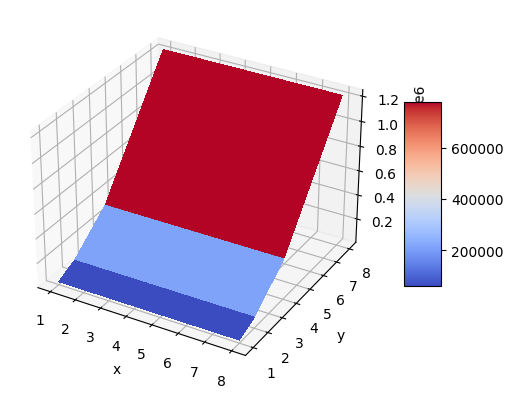

In [23]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
X, Y = np.meshgrid(bweight_list, cweight_list)
surf = ax.plot_surface(X,Y,  conditions, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [82]:
weights = {'border_weight':200,
'colloc_weight':1.5,
'connect_weights':np.array([200,10]) * 0.75
}
sol, iteration_dict = prepare_model(**weights)
A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
np.linalg.cond(A)

2063.4317417188854

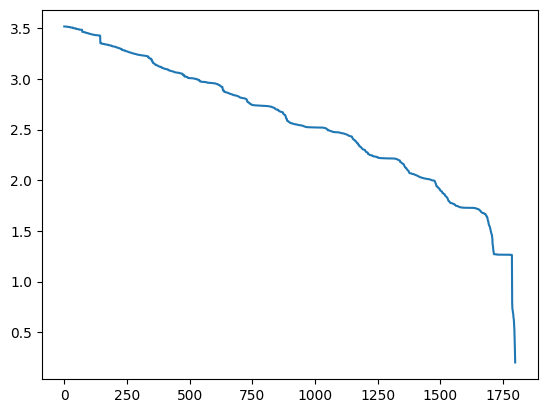

In [77]:
# print(np.linalg.cond(A))
_, s, __ = np.linalg.svd(A)
plt.plot(np.log(s)/np.log(10))

C:\Users\1\AppData\Local\Temp\ipykernel_10792\4276754745.py:1: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(abs(A[:40, :40])))
C:\Users\1\AppData\Local\Temp\ipykernel_10792\4276754745.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(abs(A)))


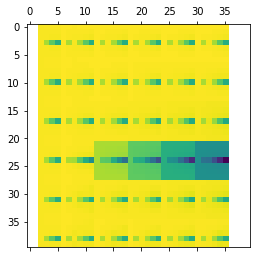

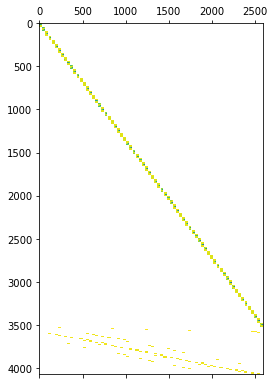

In [25]:
plt.matshow(np.log(abs(A[:40, :40])))
plt.matshow(np.log(abs(A)))

In [73]:
_, s, __ = np.linalg.svd(A)
print(s[0], s[-1])

1284.4991625396424 2.5694568763726924


In [50]:
np.linalg.cond(A)

21089.25914978681

In [75]:
s[-20:]

array([9.91911874, 9.87861291, 9.48324496, 9.18541511, 8.88373769,
       8.40783704, 7.77759719, 7.60277594, 7.5399494 , 7.53317998,
       7.42630413, 7.26437804, 6.93708161, 6.45135223, 6.44809399,
       6.44188432, 6.32454095, 6.31116282, 6.01574299, 2.56945688])

In [79]:
A, b = sol.global_solve(solver = 'SVD', **iteration_dict, return_system=True, svd_threshold=1e-8)

In [ ]:
A, b = sol.global_solve(solver = 'QR', **iteration_dict, return_system=True, svd_threshold=1e-8)

In [60]:
A, b = sol.global_solve(solver = 'np', **iteration_dict, return_system=True, svd_threshold=1e-8)

In [39]:
import copy
k=10

n=20
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)



def eval(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            # print(t, x)
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
            
    return res_array

r = np.array((k *sol.cells_coefs.shape))
for i in range(5):
    for j in range(k):
        prev_eval = eval(sol)
        prev_coefs = copy.deepcopy(sol.cells_coefs)
        A, b = sol.global_solve(solver='np', svd_threshold=1e-8, return_system=True, alpha = 0, **iteration_dict)
        print(i,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', np.max(np.abs(prev_eval - eval(sol))))
        # print(i,' | ', np.max(np.abs(prev_eval - eval(sol))))
        #print('A cond', np.linalg.cond(A))

0  |  62.53739850238051  |  31.754803462069162
0  |  1909.8798812852108  |  645.3066941527778
0  |  282243.61923790124  |  55557.202971692335
0  |  77224092.33786085  |  24935728.39221794
0  |  169344184676.8179  |  15742887977.469635


KeyboardInterrupt: 

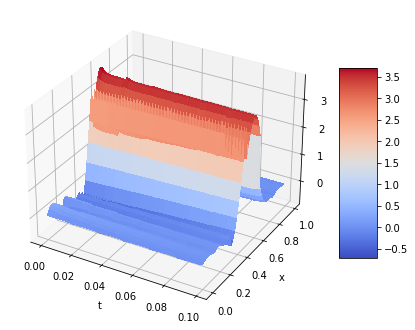

In [61]:
sol.plot2d()

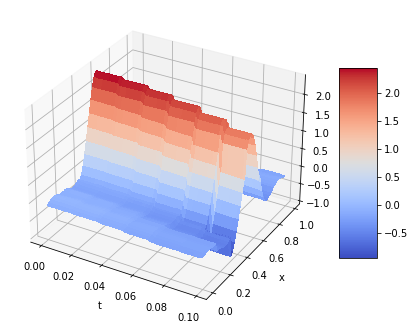

In [62]:
sol.plot2d(func_num=1, derivatives=[0,0])

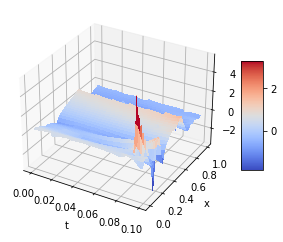

In [15]:
sol.plot2d(func_num=1, derivatives=[0,1])

In [ ]:
result = np.array()

In [11]:
np.linalg.cond(A)

1708.8557744626116

In [53]:
from solution import Solution
from basis import Basis
import itertools
import numpy as np

# SET ACCURATE PHI

a = 1
b = 1

eps = 0.2

power = 5
params = {
    'n_dims': 2,
    'dim_sizes': np.array([4, 6]),
    'area_lims': np.array([[0,0.1], [0,1]]),
    'power': power,
    'basis': Basis(power),
    'n_funcs': 1,
}

# sol = Solution(**params)
rho = Solution(**params)
phi = Solution(**params)
phi_cumulative = Solution(**params)
w = (rho.steps[0]/2)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],])
                            
border_points = connect_points

colloc_left_operators_phi = [lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0])-eps*u_bas([0,2])

                                                                                            +(rho.eval(x,[0,0])*u_bas([0,1],1)**2)/2
                                                                                            # +(u_bas([0,0],0)*u_loc([0,1],1)**2)/4

                                                                                            # -(u_bas([0,0],0)*u_loc([0,1],1)**2+
                                                                                            # 2*u_bas([0,0],0)*u_bas([0,1],1)*u_loc([0,1],1))/2/3
                                                                                            ) * w**2]
colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                            # '''
                                                                                            # +(2*u_bas([0,1],1)*u_loc([0,1],0)*u_loc([0,0],0)
                                                                                            # +u_bas([0,2],1)*u_loc([0,1],0)**2)/2
                                                                                            # '''
                                                                                            -(2*phi.eval(x,[0,1])*u_bas([0,1],0)*u_loc([0,0],0)
                                                                                            +phi.eval(x,[0,2])*u_loc([0,1],0)**2)/2

                                                                                        #         +(2*(u_bas([0,1],1)*u_loc([0,1],0)*u_loc([0,0],0)+
                                                                                        #         +u_loc([0,1],1)*u_bas([0,1],0)*u_loc([0,0],0)+
                                                                                        #         +u_loc([0,1],1)*u_loc([0,1],0)*u_bas([0,0],0))+

                                                                                        #     +u_bas([0,2],1)*u_loc([0,1],0)**2+
                                                                                        #   +2*u_loc([0,2],1)*u_bas([0,1],0)*u_loc([0,1],0))/2/3 
                                                                                          ) * w**2]
colloc_right_operators_phi = [lambda u_loc, u_nei, x, x_loc: 0]
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: 0]
colloc_ops = [colloc_left_operators, colloc_right_operators]
colloc_ops_phi = [colloc_left_operators_phi, colloc_right_operators_phi]


def terminal_state(rho,x):
    point = x
    t, x = x
    if t >= 0.0999:
        p = 6*x*(1-x)
        return rho.eval(point, [0, 0], func=0, cells_closed_right=True) - p
    else:
        return 0

def p(x):
    # return 6*x*(1-x)
    return 12*x*(1-x)*(1-x)

def initial_state(point):
    t, x = point
    if t == 0:
        return 1
    else:
        return 10*(0.1 - t)

def initial_state(point):
    t, x = point
    return 12*x*x*(1-x)

# def reversed_intitial(point):
#     t, x = point
#     # if t == 0.1:
#     #     return 1
#     # else:
#     return 10*t

border_weight = 1
small = 1e-5
border_left_operators_phi = [lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*u_bas([0,0]) * border_weight]
border_left_operators = [lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight, 
                            ]

border_right_operators_phi = [lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (rho.eval(x,[0,0],cells_closed_right=True)-p(x[1])) * border_weight]
border_right_operators = [lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x) * border_weight,
                            ]
border_ops = [border_left_operators, border_right_operators]
border_ops_phi = [border_left_operators_phi, border_right_operators_phi]



def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

# c_p_1d = f_collocation_points(int(np.ceil(power/2))).reshape(int(np.ceil(power/2))+1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

connect_points = np.array([
                            [0, -1], [0, 1],
                            [-1, 0.], [1, 0.],
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            ])

border_points = connect_points
# border_points = np.array([[1, 0.5], [1, -0.5],
#                             [0.5, -1], [0.5, 1],
#                             [-0.5, -1], [-0.5, 1],
#                             [-1, 0.5], [-1, -0.5],
#                             ])
points=[colloc_points, connect_points ,border_points]

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
#        'connect_ops':connect_ops
}

iteration_dict_phi = {'points':points,
        'colloc_ops':colloc_ops_phi,
        'border_ops':border_ops_phi,
#        'connect_ops':connect_ops
}

phi.cells_coefs *= 0.0
rho.cells_coefs *= 0.0
phi_cumulative.cells_coefs *= 0.0


In [324]:
# thresh = 1e-5

# b = 0.5

# border_right_operators = [lambda u, _, x, x_loc: int(x[0]<phi.area_lims[0,1]-small)*initial_state(x) * border_weight]
# border_left_operators = [lambda _, u_bas, x, x_loc: int(x[0]<phi.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight]
# border_ops = [border_left_operators, border_right_operators]

# colloc_weight = w**2
# colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: 0 *  colloc_weight]
# colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
#                                                                                             -(phi.eval(x,[0,1])*u_bas([0,1],0)
#                                                                                             +phi.eval(x,[0,2])*u_bas([0,0],0) - b*u_bas([0,1],0))/2
#                                                                                           ) * colloc_weight]
# colloc_ops = [colloc_left_operators, colloc_right_operators]
# iteration_dict = {'points':points,
#         'colloc_ops':colloc_ops,
#         'border_ops':border_ops,
#         'threshold':thresh
# }
# rho.solve(**iteration_dict, verbose=True)


# border_left_operators_phi = [lambda _, u_bas, x, x_loc: int(x[0]>phi.area_lims[0,0]+small)*u_bas([0,0]) * border_weight]
# border_right_operators_phi = [lambda u, _, x, x_loc: int(x[0]>phi.area_lims[0,1]-small) * (rho.eval(x-[0,1e-5],[0,0],cells_closed_right=True)-p(x[1])) * border_weight]
# border_ops_phi = [border_left_operators_phi, border_right_operators_phi]
# colloc_left_operators_phi = [lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0])-eps*u_bas([0,2])
#                                                                                             -((rho.eval(x,[0,0])-b)*u_bas([0,1]))/2
#                                                                                             )* colloc_weight]

# colloc_right_operators_phi = [lambda u_loc, u_nei, x, x_loc: (-((phi.eval(x,[0,1])**2-b**2)/4)) * colloc_weight]
# colloc_ops_phi = [colloc_left_operators_phi, colloc_right_operators_phi]
# iteration_dict_phi = {'points':points,
#         'colloc_ops':colloc_ops_phi,
#         'border_ops':border_ops_phi,
#         'threshold':thresh
# }
# phi.solve(**iteration_dict_phi, verbose=True)

In [ ]:
thresh = 1e-5

b = 0.5
a = 1

border_right_operators = [lambda u, _, x, x_loc: int(x[0]<phi.area_lims[0,1]-small)*initial_state(x) * border_weight]
border_left_operators = [lambda _, u_bas, x, x_loc: int(x[0]<phi.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight]
border_ops = [border_left_operators, border_right_operators]

colloc_weight = w**2
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: 0 *  colloc_weight]
colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                            -(phi_cumulative.eval(x,[0,1])*u_bas([0,1],0)
                                                                                            +phi_cumulative.eval(x,[0,2])*u_bas([0,0],0) - b*u_bas([0,1],0))/2/a
                                                                                          ) * colloc_weight]
colloc_ops = [colloc_left_operators, colloc_right_operators]
iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'threshold':thresh
}
rho.solve(**iteration_dict, verbose=True)

border_weight = 2

border_left_operators_phi = [lambda _, u_bas, x, x_loc: int(x[0]>phi.area_lims[0,0]+small)*u_bas([0,0]) * border_weight]
border_right_operators_phi = [lambda u, _, x, x_loc: int(x[0]>phi.area_lims[0,1]-small) * (rho.eval(x-[0,1e-5],[0,0],cells_closed_right=True)-p(x[1])) * border_weight]
border_ops_phi = [border_left_operators_phi, border_right_operators_phi]
colloc_left_operators_phi = [lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0])-eps*u_bas([0,2])
                                                                                            -((rho.eval(x,[0,0])-b)*u_bas([0,1]))/2/a
                                                                                            )* colloc_weight]

colloc_right_operators_phi = [lambda u_loc, u_nei, x, x_loc: (-((phi_cumulative.eval(x,[0,1])**2-b**2)/4)) * colloc_weight]
colloc_ops_phi = [colloc_left_operators_phi, colloc_right_operators_phi]
iteration_dict_phi = {'points':points,
        'colloc_ops':colloc_ops_phi,
        'border_ops':border_ops_phi,
        'threshold':thresh
}
phi.solve(**iteration_dict_phi, verbose=True)

phi_cumulative.cells_coefs += phi.cells_coefs * 0.2

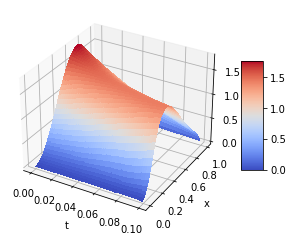

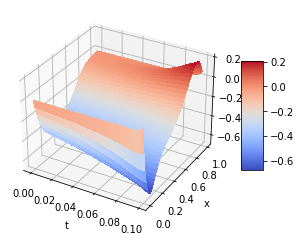

In [352]:
rho.plot2d(func_num=0)
phi.plot2d(func_num=0)

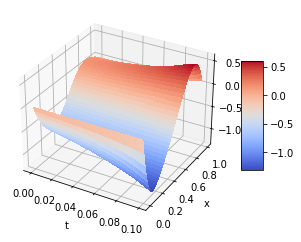

In [353]:
phi_cumulative.plot2d(func_num=0)

In [47]:
A = np.array([[1,0,1],[0,1,1],[3,1,4], [1,1,4]])

u, s, vh = np.linalg.svd(A, full_matrices=True)

In [55]:
b = np.array([1,1,0,1])
from qr_solver import QR_solve
x = QR_solve(A, b)
A @ x - b

[[-3 -1 -5]
 [ 1 -1 -1]
 [ 0  0  1]
 [ 0  0  0]]


array([-1.33333333e+00,  0.00000000e+00,  5.55111512e-17, -3.33333333e-01])

In [22]:
rot_b = np.transpose(u) @ b
rot_x = rot_b[:len(s)] / s
x = np.transpose(vh) @ rot_x

In [57]:
s

array([6.73101768, 1.50484102, 0.65486983])

In [65]:
pinv @ A

array([[ 1.00000000e+00, -2.22044605e-16, -4.44089210e-16],
       [-2.77555756e-16,  1.00000000e+00,  4.44089210e-16],
       [ 0.00000000e+00,  3.88578059e-16,  1.00000000e+00]])

In [50]:
x = pinv @ b

In [52]:
A @ x - b

array([-1.09090909, -0.36363636,  0.36363636,  0.        ])

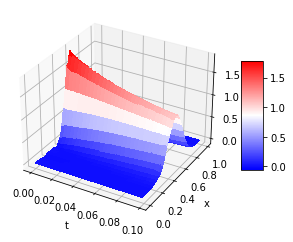

In [46]:
import matplotlib.pyplot as plt
n = 60
func = np.zeros((n,n))
x_lims = sol.area_lims[0]
y_lims = sol.area_lims[1]
ax1 = np.linspace(x_lims[0], x_lims[1], n, endpoint=False)
ax2 = np.linspace(y_lims[0], y_lims[1], n, endpoint=False)
X, Y = np.meshgrid(ax1, ax2)

for i in range(n):
    for j in range(n): 
        # func[j, i] = rho.eval([ax1[i], ax2[j]], [0,0])
        func[j, i] = sol.eval([ax1[i], ax2[j]], [0,0], func=0)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, func, cmap='bwr',#cmap=cm.coolwarm,
                linewidth=0, antialiased=False)

# ax.set_xticks(X)
# ax.set_xticks(Y)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('t')
ax.set_ylabel('x')
plt.show()

In [52]:
intrested = [p(x) for x in np.linspace(0,1,n)]
np.sum(intrested)/n

0.3280666475150819

([<matplotlib.axis.XTick at 0x22d800dda30>,
 [Text(0, 0, '0'),
  Text(15, 0, '0.25'),
  Text(30, 0, '0.5'),
  Text(45, 0, '0.75'),
  Text(60, 0, '1')])

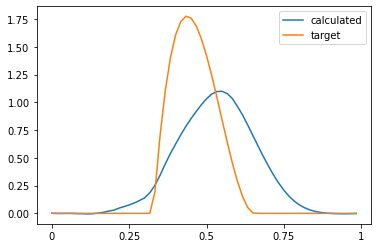

In [48]:
plt.plot(func[:,-1])
plt.plot(intrested)
plt.legend(['calculated','target'])
plt.xticks([0, 15, 30, 45, 60], [0, 0.25, 0.5, 0.75, 1])

In [54]:
np.sum(func[:,-1])/len(func)

0.32965962766252155

0.6734687666885419


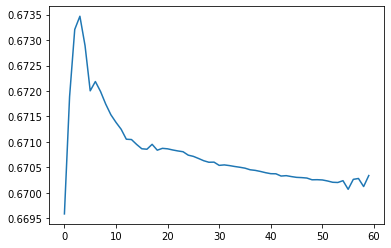

In [49]:
x = []
for i in range(len(func[0])):
    x.append(abs(np.sum(func[:,i])/n - 1))
print(np.max(x))
plt.plot(x)

In [358]:
def f(point):
    t,x = point
    T = 0.1
    bracket = (rho_t(point) - eps*rho_xx(point))/(-phi.eval(point,[1,0]) - phi.eval(point,[0,2]))
    return np.log10(abs(bracket - phi.eval(point,[0,1])/2 - np.sqrt((bracket + phi.eval(point,[0,1])/2)**2 + rho_x(point)/2)))

def f(point):
    t,x = point
    T = 0.1
    bracket = (rho.eval(point,[1,0]) - eps*rho.eval(point,[0,2]))/(-phi.eval(point,[1,0]) - phi.eval(point,[0,2]))
    return np.log10(abs(bracket - phi.eval(point,[0,1])/2 - np.sqrt((bracket + phi.eval(point,[0,1])/2)**2 + rho.eval(point,[0,1])/2)))

C:\Users\1\AppData\Local\Temp\ipykernel_3844\3010183850.py:29: RuntimeWarning: invalid value encountered in sqrt
  return np.log10(abs(bracket - phi.eval(point,[0,1])/2 - np.sqrt((bracket + phi.eval(point,[0,1])/2)**2 + rho.eval(point,[0,1])/2)))


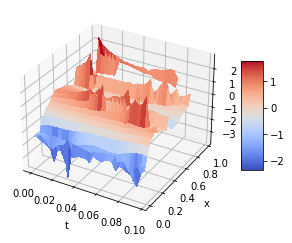

In [359]:
import matplotlib.pyplot as plt
from matplotlib import cm
n=30
func = np.zeros((n,n))
x_lims = phi.area_lims[0]
y_lims = phi.area_lims[1]
ax1 = np.linspace(x_lims[0], x_lims[1], n, endpoint=False)
ax2 = np.linspace(y_lims[0], y_lims[1], n, endpoint=False)
X, Y = np.meshgrid(ax1, ax2)

for i in range(n):
    for j in range(n): 
        func[j, i] = f([ax1[i], ax2[j]])

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, func, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)

# ax.set_xticks(X)
# ax.set_xticks(Y)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('t')
ax.set_ylabel('x')
# ax.set_zscale('log') 
plt.show()

In [197]:
func[np.isnan(func)] = 0

In [198]:
np.mean(func)

0.041583613911817155

In [199]:
np.max(func)

2.5867709109913735

In [200]:
np.min(func)

-3.319747788951779

In [419]:
thresh = 1e-5

chi = Solution(**params)
eta = Solution(**params)
rho_inverse = Solution(**params)
phi_inverse = Solution(**params)
phi_cumulative_inv = Solution(**params)
chi.cells_coefs *= 0.0
eta.cells_coefs *= 0.0
rho_inverse.cells_coefs *= 0.0
phi_inverse.cells_coefs *= 0.0
phi_cumulative_inv.cells_coefs *= 0.0


In [ ]:
b = 0.5
a = 1

border_right_operators = [lambda u, _, x, x_loc: 0 * border_weight]
border_left_operators = [lambda _, u_bas, x, x_loc: int(x[0]>phi.area_lims[0,1]+small)*u_bas([0,0],0) * border_weight]
border_ops = [border_left_operators, border_right_operators]

colloc_weight = w**2
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-eta.eval(point,[0,0])*phi_cumulative_inv.eval(x,[0,1]) + 2*(rho_inverse.eval(x,[0,0]) - rho.eval(x,[0,0]))
                                                                                                                ) *  colloc_weight]
colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  2*a*(-u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                            +b*u_bas([0,1])
                                                                                          ) * colloc_weight]
colloc_ops = [colloc_left_operators, colloc_right_operators]
iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'threshold':thresh
}
chi.solve(**iteration_dict, verbose=True)

In [ ]:

border_left_operators_eta = [lambda _, u_bas, x, x_loc: int(x[0]<phi.area_lims[0,0]-small)*u_bas([0,0]) * border_weight]
border_right_operators_eta = [lambda u, _, x, x_loc: 0]#int(x[0]>phi.area_lims[0,1]-small) * (rho.eval(x-[0,1e-5],[0,0],cells_closed_right=True)-p(x[1])) * border_weight]
border_ops_eta = [border_left_operators_eta, border_right_operators_eta]
colloc_left_operators_eta = [lambda u_loc, u_bas, x, x_loc:  2*a*(u_bas([1,0])-eps*u_bas([0,2])
                                                                                            +b*u_bas([0,1])
                                                                                            )* colloc_weight]

colloc_right_operators_eta = [lambda u_loc, u_nei, x, x_loc: (chi.eval(x,[0,2])*rho_inverse.eval(x,[0,0])**2) * colloc_weight]
colloc_ops_eta = [colloc_left_operators_eta, colloc_right_operators_eta]
iteration_dict_eta = {'points':points,
        'colloc_ops':colloc_ops_eta,
        'border_ops':border_ops_eta,
        'threshold':thresh
}
eta.solve(**iteration_dict_eta, verbose=True)

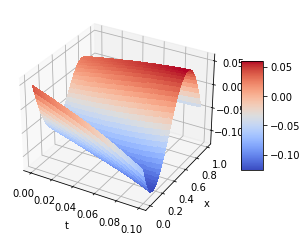

In [397]:
chi.plot2d()

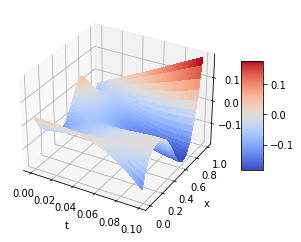

In [398]:
eta.plot2d()

In [409]:
#a, b gradient
n=40
ax1 = np.linspace(x_lims[0], x_lims[1], n, endpoint=False)
ax2 = np.linspace(y_lims[0], y_lims[1], n, endpoint=False)
func = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        x = [ax1[i], ax2[j]]
        func[i, j] = chi.eval(x,[0,0])*(rho_inverse.eval(x,[1,0]) - eps*rho_inverse.eval(x,[0,1]))+2*eta.eval(x,[0,0])*(-phi_inverse.eval(x,[1,0]) - eps*phi_inverse.eval(x,[0,2]))


In [410]:
Ja = np.sum(func)/n/n/10
Ja

-0.000505472314056493

In [407]:
n=40
ax1 = np.linspace(x_lims[0], x_lims[1], n, endpoint=False)
ax2 = np.linspace(y_lims[0], y_lims[1], n, endpoint=False)
func = np.zeros((n,n))
for i in range(n):
    for j in range(n): 
        x = [ax1[i], ax2[j]]
        func[i, j] = rho_inverse.eval(x,[0,0])*chi.eval(x,[0,1])+phi_inverse.eval(x,[0,1])*eta.eval(x,[0,0])
Jb = np.sum(func)/n/n/10
Jb

0.008710453133347099

In [322]:
list(zip([1,2,3,4],[1]))

[(1, 1)]

In [423]:
thresh = 1e-5
#-0.3027867 , -0.87342671
b = 0.87342671#0.4
a = 0.3027867#1.1

border_right_operators = [lambda u, _, x, x_loc: int(x[0]<phi.area_lims[0,1]-small)*initial_state(x) * border_weight]
border_left_operators = [lambda _, u_bas, x, x_loc: int(x[0]<phi.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight]
border_ops = [border_left_operators, border_right_operators]

colloc_weight = w**2
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: 0 *  colloc_weight]
colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                            -(phi_cumulative_inv.eval(x,[0,1])*u_bas([0,1],0)
                                                                                            +phi_cumulative_inv.eval(x,[0,2])*u_bas([0,0],0) - b*u_bas([0,1],0))/2/a
                                                                                          ) * colloc_weight]
colloc_ops = [colloc_left_operators, colloc_right_operators]
iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'threshold':thresh
}
rho_inverse.solve(**iteration_dict, verbose=True)

border_weight = 2

border_left_operators_phi = [lambda _, u_bas, x, x_loc: int(x[0]>phi.area_lims[0,0]+small)*u_bas([0,0]) * border_weight]
border_right_operators_phi = [lambda u, _, x, x_loc: int(x[0]>phi.area_lims[0,1]-small) * (rho.eval(x-[0,1e-5],[0,0],cells_closed_right=True)-p(x[1])) * border_weight]
border_ops_phi = [border_left_operators_phi, border_right_operators_phi]
colloc_left_operators_phi = [lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0])-eps*u_bas([0,2])
                                                                                            -((rho.eval(x,[0,0])-b)*u_bas([0,1]))/2/a
                                                                                            )* colloc_weight]

colloc_right_operators_phi = [lambda u_loc, u_nei, x, x_loc: (-((phi_cumulative_inv.eval(x,[0,1])**2-b**2)/4)) * colloc_weight]
colloc_ops_phi = [colloc_left_operators_phi, colloc_right_operators_phi]
iteration_dict_phi = {'points':points,
        'colloc_ops':colloc_ops_phi,
        'border_ops':border_ops_phi,
        'threshold':thresh
}
phi_inverse.solve(**iteration_dict_phi, verbose=True)

phi_cumulative_inv.cells_coefs += phi_inverse.cells_coefs * 0.4

0.11005324211013384
0.07547841118590894
0.03631173925834397
0.021690333377529902
0.010759797851394248
0.005548878193818135
0.0030266321398505075
0.0014095892846665153
0.0006776486836058693
0.00044727195866989256
0.00024682404018481086
0.0001619682372986063
0.00010012642405327413
4.8659901155621854e-05
2.5209508905022935e-05
1.2434028984579897e-05
7.62263794803434e-06
Iterations to converge:  16
0.021488740782367288
0.011321238964525825
0.005560864849515519
0.003516211851055495
0.002888269207870553
0.002458521799276081
0.0016826639017020195
0.0009116586717909381
0.00045326080449097084
0.00026410446483349226
0.00010700725832745589
6.218771487877077e-05
2.6990920802685142e-05
1.6306664917239977e-05
8.383279321177994e-06
Iterations to converge:  14


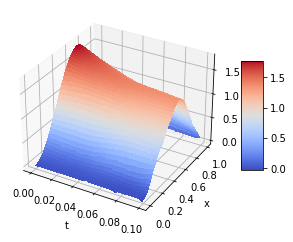

In [426]:
rho_inverse.plot2d()

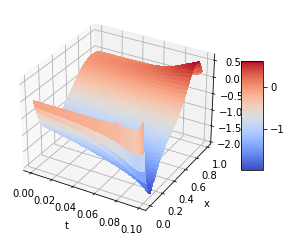

In [417]:
phi_cumulative_inv.plot2d()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (60, 60) and arg 2 with shape (30, 30).

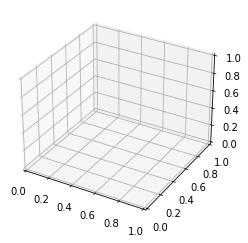

In [429]:
import matplotlib.pyplot as plt
from matplotlib import cm
n=60
func1 = np.zeros((n,n))
func2 = np.zeros((n,n))
x_lims = phi.area_lims[0]
y_lims = phi.area_lims[1]
ax1 = np.linspace(x_lims[0], x_lims[1], n, endpoint=False)
ax2 = np.linspace(y_lims[0], y_lims[1], n, endpoint=False)
X, Y = np.meshgrid(ax1, ax2)

for i in range(n):
    for j in range(n): 
        func1[j, i] = rho.eval([ax1[i], ax2[j]],[0,0])#np.abs(rho.eval([ax1[i], ax2[j]],[0,0]) - rho_inverse.eval([ax1[i], ax2[j]],[0,0]))
        func2[j,i] = rho_inverse.eval([ax1[i], ax2[j]],[0,0])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, func, cmap=cm.coolwarm,
                linewidth=0, antialiased=False)

# ax.set_xticks(X)
# ax.set_xticks(Y)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('t')
ax.set_ylabel('x')
plt.show()

([<matplotlib.axis.XTick at 0x2897f5f5d30>,
 [Text(0, 0, '0'),
  Text(15, 0, '0.25'),
  Text(30, 0, '0.5'),
  Text(45, 0, '0.75'),
  Text(60, 0, '1')])

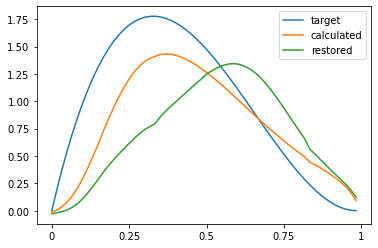

In [432]:
plt.plot(intrested)
plt.plot(func1[:,-1])
plt.plot(func2[:,-1])

plt.legend(['target', 'calculated', 'restored'])
plt.xticks([0, 15, 30, 45, 60], [0, 0.25, 0.5, 0.75, 1])

In [6]:
# SIR DIRECT PROBLEM STATEMENT

from solution_global_wip import Solution
from basis import Basis
import itertools
import numpy as np

eps = 0.0

beta = 0.2
gamma = 0.02
N = 1

power = 6
params = {
    'n_dims': 2,
    'dim_sizes': np.array([12, 12]),
    'area_lims': np.array([[0,5], [0,1]]),
    'power': power,
    'basis': Basis(power),
    'n_funcs': 6,
}
sol = Solution(**params)
w = (sol.steps[0]/2)
c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],])
                            
# border_points = connect_points
border_points =  ([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0.75],[-1, 0.25],[-1, -0.75],[-1, -0.25], [-1, 0]
                            
                            ])

colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],3)-eps*u_bas([0,2],3)
                                                                                            # -(u_bas([0,0],0)*u_loc([0,1],1)**2+
                                                                                            # 2*u_bas([0,0],0)*u_loc([0,1],1)*u_loc([0,1],1))/2/3
                                                                                            -(u_bas([0,0],0)*u_loc([0,1],3)**2+
                                                                                            2*u_bas([0,0],0)*u_loc([0,1],3)*u_loc([0,1],3))/2/3
                                                                                            
                                                                                            + beta*u_bas([0,0],3)*u_loc([0,0],1)/N

                                                                                            ) * w**2 , #dpsi s
                        lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],4)-eps*u_bas([0,2],4)
                                                                                            -(u_bas([0,0],1)*u_loc([0,1],4)**2+
                                                                                            2*u_bas([0,0],1)*u_loc([0,1],4)*u_loc([0,1],4))/2/3
                                                                                            
                                                                                            -beta*u_bas([0,0],0)*u_loc([0,0],4)/N
                                                                                            +gamma*u_bas([0,0],4)

                                                                                            ) * w**2 , #dpsi i
                        lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],5)-eps*u_bas([0,2],5)
                                                                                            -(u_bas([0,0],2)*u_loc([0,1],5)**2+
                                                                                            2*u_bas([0,0],2)*u_loc([0,1],5)*u_loc([0,1],5))/2/3
                                                                                            
                                                                                            -gamma*u_bas([0,0],1)

                                                                                            ) * w**2 , #dpsi r

                                                                                            
                         lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                             +(2*u_bas([0,1],1)*u_loc([0,1],0)*u_loc([0,0],0)
                                                                                             +u_bas([0,2],1)*u_loc([0,1],0)**2)/2    

                                                                                            # +(2*u_bas([0,1],3)*u_loc([0,1],0)*u_loc([0,0],0)
                                                                                            # +u_bas([0,2],3)*u_loc([0,1],0)**2)/2
                                                                                            # +(2*u_loc([0,1],3)*u_bas([0,1],0)*u_loc([0,0],0)
                                                                                            # +u_bas([0,2],3)*u_loc([0,1],0)**2)/2

                                                                                             +beta*u_bas([0,0],0)*u_loc([0,0],1)/N
                                                                                            
                                                                                          ) * w**2, #ds
                        lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                            +(2*u_bas([0,1],4)*u_loc([0,1],1)*u_loc([0,0],1)
                                                                                            +u_bas([0,2],4)*u_loc([0,1],1)**2)/2

                                                                                            -beta*u_bas([0,0],0)*u_loc([0,0],1)/N
                                                                                            +gamma*u_bas([0,0],1)
                                                        
                                                                                          ) * w**2, #di
                        lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],2)-eps*u_bas([0,2],2)
                                                                                            +(2*u_bas([0,1],5)*u_loc([0,1],2)*u_loc([0,0],2)
                                                                                            +u_bas([0,2],5)*u_loc([0,1],2)**2)/2

                                                                                            -gamma*u_bas([0,0],1)

                                                                                          ) * w**2,] #dr
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: 0,
                          lambda u_loc, u_nei, x, x_loc: 0,
                          lambda u_loc, u_nei, x, x_loc: 0,
                          lambda u_loc, u_nei, x, x_loc: 0,
                          lambda u_loc, u_nei, x, x_loc: 0,
                          lambda u_loc, u_nei, x, x_loc: 0]
colloc_ops = [colloc_left_operators, colloc_right_operators]

def p(x):
    # return 6*x*(1-x)
    return np.array([0, 0, 0])


sigma = 0.03
def initial_state(point):
    t, x = point
    # return np.array([0.98, 0.02, 0]) * np.exp((-((x-0.5)/sigma)**2)/2)#*(1/sigma/np.sqrt(2*3.141592)) #12*x*x*(1-x)
    sm_x = (x+1)/3
    if (x<2/3 and x>1/3):
        return np.array([0.98, 0.02, 0]) * (12*sm_x*sm_x*(1-sm_x))
    else:
        return np.array([0,0,0])

border_weight = 1
small = 1e-5

border_left_operators = [#lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*u_bas([0,0],1) * border_weight,
                        #  lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],3)-u_bas([0,0],0)) * border_weight/ 10,
                         lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],3)) * border_weight,
                         lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight, 
                         
                         lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],4)-u_bas([0,0],1)) * border_weight,
                        #  lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],4)) * border_weight,
                         lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],1) * border_weight, 
                         

                        #  lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],5)-u_bas([0,0],2)) * border_weight/ 10,
                         lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],5)) * border_weight,
                         lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],2) * border_weight, 
                         ]

border_right_operators = [#lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (u([0,0],0)-p(x[1])) * border_weight,
                          lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-p(x[1])[0]) * border_weight,
                          lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x)[0] * border_weight,

                          lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-p(x[1])[1]) * border_weight,
                          lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x)[1] * border_weight,

                          lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-p(x[1])[2]) * border_weight,
                          lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x)[2] * border_weight,
                            ]
border_ops = [border_left_operators, border_right_operators]



def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

# c_p_1d = f_collocation_points(int(np.ceil(power/2))).reshape(int(np.ceil(power/2))+1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            ])
border_points = np.array([[1, 0.5], [1, -0.5],
                            [0.5, -1], [0.5, 1],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0.5], [-1, -0.5],
                            ])
points=[colloc_points, connect_points ,border_points]

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
#        'connect_ops':connect_ops
}

sol.cells_coefs *= 0.0

In [7]:
sol.global_solve(solver='np', **iteration_dict)

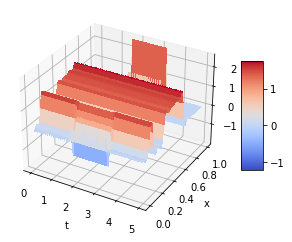

In [23]:
sol.plot2d(func_num=0)

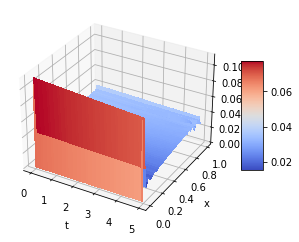

In [11]:
sol.plot2d(func_num=1)

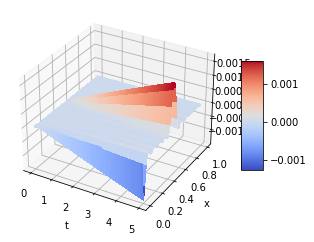

In [23]:
sol.plot2d(func_num=2)

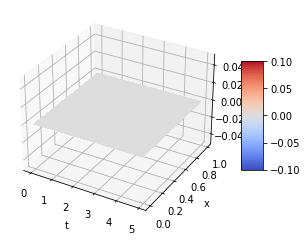

In [10]:
sol.plot2d(func_num=3)

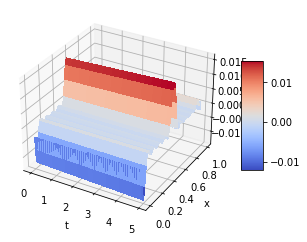

In [11]:
sol.plot2d(func_num=4)

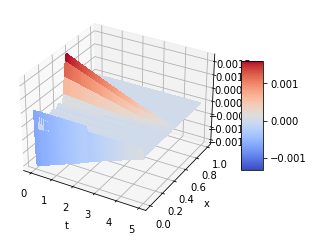

In [12]:
sol.plot2d(func_num=5)

In [ ]:
#INVERSE SIR PROBLEM

params = {
    'n_dims': 2,
    'dim_sizes': np.array([5, 5]),
    'area_lims': np.array([[0,5], [0,1]]),
    'power': power,
    'basis': Basis(power),
    'n_funcs': 6,
}

adjoint_sol = Solution(**params)

inverse_sol = Solution(**params)

b = 0.5
a = 1

border_right_operators = [lambda u, _, x, x_loc: 0 * border_weight]
border_left_operators = [lambda _, u_bas, x, x_loc: int(x[0]>phi.area_lims[0,1]+small)*u_bas([0,0],0) * border_weight]
border_left_operators_eta = [lambda _, u_bas, x, x_loc: int(x[0]<phi.area_lims[0,0]-small)*u_bas([0,0]) * border_weight]
border_right_operators_eta = [lambda u, _, x, x_loc: 0]#int(x[0]>phi.area_lims[0,1]-small) * (rho.eval(x-[0,1e-5],[0,0],cells_closed_right=True)-p(x[1])) * border_weight]


border_ops = [border_left_operators, border_right_operators]


# chi = 0, eta = 1

colloc_weight = w**2

colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  2*a*(-u_bas([1,0],0)-eps*u_bas([0,2],0) + b * u_bas([0,1], 0)
                                                                                          ) * colloc_weight,
                          lambda u_loc, u_bas, x, x_loc:  2*a*(-u_bas([1,0],0)-eps*u_bas([0,2],0) + b * u_bas([0,1], 0)
                                                                                          ) * colloc_weight,
                          lambda u_loc, u_bas, x, x_loc:  2*a*(-u_bas([1,0],0)-eps*u_bas([0,2],0) + b * u_bas([0,1], 0)
                                                                                          ) * colloc_weight]




colloc_left_operators_eta = [lambda u_loc, u_bas, x, x_loc:  2*a*(u_bas([1,0])-eps*u_bas([0,2])
                                                                                            +b*u_bas([0,1])
                                                                                            )* colloc_weight]


colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-eta.eval(point,[0,0])*phi_cumulative_inv.eval(x,[0,1]) + 2*(rho_inverse.eval(x,[0,0]) - rho.eval(x,[0,0]))
                                                                                                                ) *  colloc_weight]

colloc_right_operators_eta = [lambda u_loc, u_nei, x, x_loc: (chi.eval(x,[0,2])*rho_inverse.eval(x,[0,0])**2) * colloc_weight]


colloc_ops = [colloc_left_operators, colloc_right_operators]
iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'threshold':thresh
}
chi.solve(**iteration_dict, verbose=True)



In [82]:
#simple direct problem solving 

import matplotlib.pyplot as plt

from solution_global_wip import Solution
from basis import Basis
import itertools
import numpy as np

a = 1
b = 1

eps = 0.005

beta = 0.2
gamma = 0.15


power = 5
params = {
    'n_dims': 2,
    'dim_sizes': np.array([6, 6]),
    'area_lims': np.array([[0,1], [0,1]]),
    'power': power,
    'basis': Basis(power),
    'n_funcs': 2,
}
sol = Solution(**params)
w = np.sqrt(2) #(sol.steps[0]/2)
# w = 1/sol.steps[0]
k1 = 50
k2 = 5
border_weight = sol.steps[0]**(-1) * 100
no_need_weight = 0
# border_weight = 100

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

# c_p_1d = f_collocation_points(int(np.ceil(power/2))).reshape(int(np.ceil(power/2))+1)
# power = int(3/2*power)
c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],])
                            
border_points = connect_points

colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0) #s
                                                                                            -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                              u_loc([0,1],0)*u_bas([0,1],1)+

                                                                                             u_loc([0,0],0)*u_bas([0,2],1)+
                                                                                             u_bas([0,0],0)*u_loc([0,2],1))
                                                                                          ) * w**2,
                        
                        lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                             +(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                            ) * w**2 ,
                                                                                            ]

                                            

def popravka(f,g):
    return f*g
colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: (-popravka(u_loc([0,1],0), u_loc([0,1],1)) - popravka(u_loc([0,0],0), u_loc([0,2],1))) * w**2,
                
                          lambda u_loc, u_nei, x, x_loc: (0) * w**2,
                          
                          ]
colloc_ops = [colloc_left_operators, colloc_right_operators]


def initial_state(x):
    t, x = x
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return 12*sm_x**2 *(1-sm_x) *3
    else:
        return 0

def terminal_state(x):
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return  12*sm_x*(1-sm_x)**2 *3
    else:
        return 0

small = 1e-5

# border_left_operators = [lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
                         
#                         lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],1)-u_bas([0,0],0)) * border_weight,
                         
#                         lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight,
#                             ]

border_left_operators = [
    #s_PSI border conditions
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
                         
    # lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],3)-u_bas([0,0],0)) * border_weight, #* no_need_weight,
    lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],1)-u_bas([0,0],0)) * border_weight, #* no_need_weight,
            
    lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight,
    ]

border_right_operators = [
    lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi-s
                            
    # terminal conditions for psis
    lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-terminal_state(x[1])) * border_weight,
                            
    lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x) * border_weight, # border and initial cond for s
    ]

border_ops = [border_left_operators, border_right_operators]

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
points=[colloc_points, connect_points ,border_points]

connect_left_operators = []
connect_right_operators = []

def dir(point: np.array) -> np.array:
    direction = (np.abs(point) == 1) * (np.sign(point))
    return np.array(direction, dtype=int)
for func_num in range(sol.n_funcs):
    # connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc),func_num) + np.sum(dir(x_loc))*int(abs(x_loc[1])==1)*u_bas([0,1],func_num)]
    # connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc),func_num) -  np.sum(dir(x_loc))*int(abs(x_loc[1])==1)*u_bas([0,1],func_num)]
    connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
    connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
connect_ops = [connect_left_operators, connect_right_operators]

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
       'connect_ops':connect_ops
}

sol.cells_coefs *= 0.0


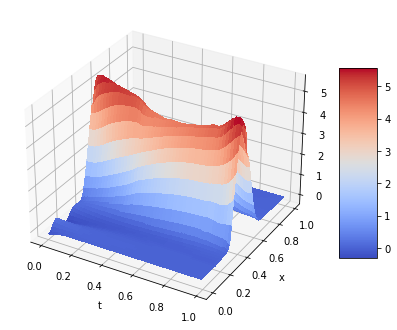

In [89]:
for i in range(30):
    A, b = sol.global_solve(solver = 'np', **iteration_dict, return_system=True, svd_threshold=1e-8)
sol.plot2d()

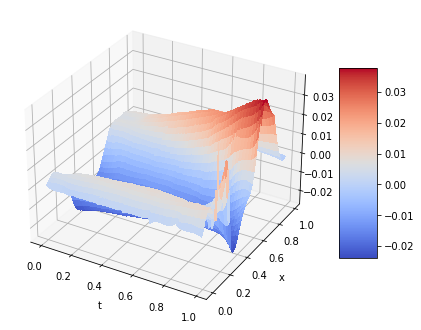

In [90]:
sol.plot2d(func_num=1)

Matrix conditioning: 1269662.7241295865


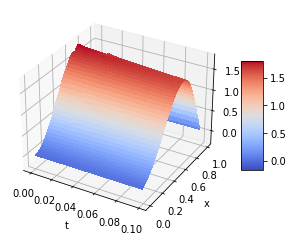

In [136]:
A, b = sol.global_solve(solver = 'SVD', **iteration_dict, return_system=True, svd_threshold=1e-8)
sol.plot2d()

C:\Users\1\AppData\Local\Temp\ipykernel_21868\3510173484.py:1: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(abs(A)))


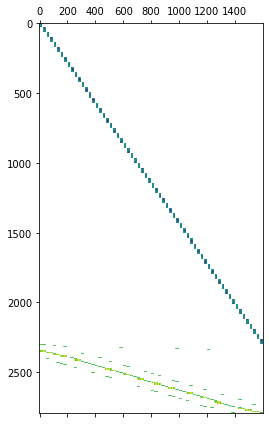

In [134]:
plt.matshow(np.log(abs(A)))